In [1]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings 

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


ROOT = Path.cwd().parent
DATA = ROOT / "data"


sys.path.append(str(ROOT / "functions"))
from utils import * 
from num_functions import *

Data import

In [ ]:
train_path = DATA / "train_merged.csv"
df = pd.read_csv(train_path, low_memory=False)
print(df.shape)

(590540, 434)
Memory usage decreased to 645.97 Mb (67.0% reduction)


In [ ]:
train_df = reduce_mem_usage(df.copy())

#### Missing Values

Elimizdeki veri sentetik değil , ufak bir değişiklik bile asıl pattern i bozabilir haliyle eksik değerler için çoğunluğu eksik olan sütunların silinmesi kalanlar içi nde doldurma yöntemlerinin iyice değerlendirilmesi gerekmektedir.

In [12]:
threshold = 95 # %95 ten fazlası eksik olan feature lar modele 
high_missing = top_missing_cols(train_df, thresh=threshold)
cols_to_drop = high_missing[high_missing['missing_percent'] > threshold]['col'].tolist()

train_df = train_df.drop(columns=cols_to_drop)
print(f" Threshold : {threshold}%\n Dropped feature num : {len(cols_to_drop)}")
# Features with missing values exceeding the 95% threshold were dropped.

There are 414 columns with missing values.
There are 9 columns with missing percent > 95%
 Threshold : 95%
 Dropped feature num : 9


# Target Anlysis

The target variable "isFraud" is a binary variable and represents whether the record is involved in fraudulent activity.

Approximately 3.5% of train data has a value of “isFraud = 1”. 

Class distribution for 'isFraud':
isFraud
0    569877
1     20663
Name: count, dtype: int64

Percentage:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


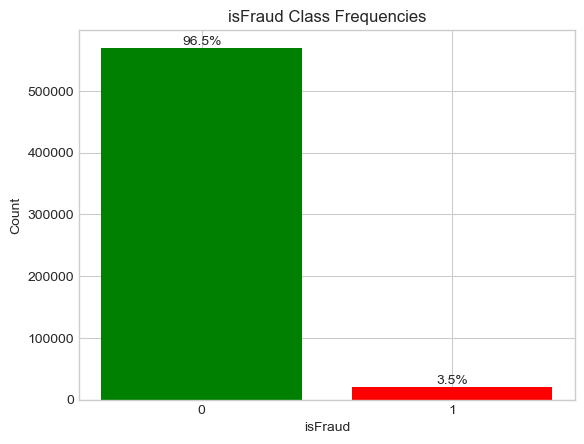

In [5]:
print("Class distribution for 'isFraud':")
print(train_df['isFraud'].value_counts())
print("\nPercentage:")
print(train_df['isFraud'].value_counts(normalize=True))

counts = train_df['isFraud'].value_counts()
percentages = train_df['isFraud'].value_counts(normalize=True) * 100

colors = ['green', 'red'] 
bars = plt.bar(counts.index, counts.values, color=colors[:len(counts)])

plt.title('isFraud Class Frequencies')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks([0, 1])

for bar, perc in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{perc:.1f}%', ha='center', va='bottom')

plt.show()

Separation of numerical and categorical features

In [67]:
categorical_features = [
    'ProductCD', 'P_emaildomain', 'R_emaildomain','DeviceType', 'DeviceInfo',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
    'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]
numerical_features = [col for col in train_df.columns if col not in categorical_features]

present_cat_cols = list(set(categorical_features) & set(train_df.columns)) # After Dropping Missing data.

# resumetable(train_df[categorical_features])[:15]

# Categorical Feature Analysis

The company providing the data has specified which features in the dataset are categorical.

We can basically divide the features we have into two main groups: Transaction and Identity.

**Categorical features under Transaction**:

ProductCD: Transaction product code.

card1–card6: Card type, card country, etc. card information.

addr1, addr2: Geographic address information.

P_emaildomain: Purchaser email domain.

R_emaildomain: Recipient email domain.

M1–M9: Matching statuses (cardholder–address match, etc.)


**Categorical attributes under Identity**: 

DeviceType: Type of device used in the transaction.

DeviceInfo: Device information (model, manufacturer, etc.)

id_12–id_38: Network connection, browser information, and various session attributes.

---

It seems that some features specified as categorical have very high cardinality. These features will either be examined as numerical features or excluded from the study.

In [68]:
cardinality_threshold = 15
low_cardinality = [col for col in present_cat_cols if train_df[col].nunique() <= cardinality_threshold]
high_cardinality = [col for col in present_cat_cols if train_df[col].nunique() > cardinality_threshold]

categorical_features = low_cardinality
cardinality_features = high_cardinality # excluded

Similar groups have similar names in the categorical_features list. We can examine these groups among themselves.

In [69]:
card_features = [col for col in train_df[categorical_features].columns if col.startswith('card')]
cat_id_features = [col for col in train_df[categorical_features].columns if col.startswith('id_')]
M_features = [col for col in train_df[categorical_features].columns if col.startswith('M') and len(col) == 2]
kalan = card_features + cat_id_features + M_features
indep_cat_features = [col for col in train_df[categorical_features].columns if col not in kalan ]


In [70]:
len(categorical_features) == len(card_features) + len(cat_id_features) + len(M_features) + len(indep_cat_features)

True

We know that the card3 and card5 variables are categorical. Some studies have shown that classifying subcategories with very low frequencies as “Others” has a positive effect on the result.

On the other hand, it is not appropriate to examine the car1 and card2 features as categorical.

Additionally, we focus on extracting meaning from as much of our categorical data as possible. To this end, I have written some functions: 

1. **clean_email_domains**
Consolidates email domains (P_emaildomain and R_emaildomain) into major provider categories
Maps various domain extensions (e.g., gmail.com, googlemail.com) to their parent companies (google, microsoft, yahoo, apple, etc.)
Reduces cardinality by grouping similar domains under common provider names
Helps identify patterns related to email service providers rather than specific domain variations.

2. **analyze_email_match**
Creates a new feature called email_match that compares purchaser and recipient email domains
Assigns three possible values:
'Match': Both emails exist and use the same provider
'Different': Both emails exist but use different providers
'Unknown/Missing': One or both email fields are missing
This feature can indicate fraud risk, as mismatched or missing email pairs may signal suspicious transactions

3. **consolidate_device_info**
Standardizes device-related features (id_30 for OS and DeviceInfo for device details)
Groups operating systems and device types into broader categories (e.g., Windows, iOS, Android, Samsung, etc.)
Reduces high cardinality in device information by consolidating variations into main device families
Improves model generalization by focusing on device categories rather than specific models

In [71]:
# for card3 , <200 -->others
valid_card3 = train_df['card3'].value_counts()
train_df.loc[train_df['card3'].isin(valid_card3[valid_card3 < 200].index), 'card3'] = "Others"

# for card5 , <300 --> others 
valid_card5 = train_df['card5'].value_counts()
train_df.loc[train_df['card5'].isin(valid_card5[valid_card5 < 300].index), 'card5'] = "Others"

# The same procedures should also be applied to the test data! 
train_df = (train_df
    .pipe(clean_email_domains)
    .pipe(analyze_email_match)
    .pipe(consolidate_device_info))

* Filling in missing values.
* Target Encoding, Frequency Encoding.
* Scaling/Normalization.
* ..

When applying these operations, we must ensure that they are learned only from the training data.

---

Elimizdeki veri İşlem tarafnda zamansal olduğu için buna dayalı özellikler analiz edilmelidir. Bu amaçla analyze_time_categories kullanılır : 

Purpose: Extracts temporal features from the TransactionDT column and analyzes fraud patterns across different time periods.

What it does:

* Creates hour feature: Extracts the hour of day (0-23) from transaction timestamp.
* Creates day_of_week feature: Extracts the day of week (0-6) from transaction timestamp.
* Generates visualizations showing transaction volume and fraud rate patterns across hours and days Uses deterministic mathematical transformations (modulo operations) on the timestamp.

When deriving features, no statistics are learned from the existing data; deterministic transformations are performed. 
Therefore, the function does not have the data leakage risk. It is only important that the same process is applied to the test data! 

In [ ]:
train_df = analyze_time_categories(train_df)

### Categorical Feature Importance Test Before Modeling

Elimizdeki kategorik verileri başlangıçta kardinalitesi düşük ve yüksek olacak şekilde ayırdık. Yüksek kardinaliteye sahip bazı özellikleri çeşitli feature engineering yöntemleriyle kullanılabilir şekilde dönüştürdük .Elimizdeki tüm kategorik özelliklere bir bakalım.

In [73]:
card_features = list(set([col for col in categorical_features if col.startswith('card')] + ["card3", "card5"]))
cat_id_features = [col for col in categorical_features if col.startswith('id_')]
M_features = [col for col in categorical_features if col.startswith('M') and len(col) == 2]

excluded_features = card_features + cat_id_features + M_features
indep_cat_features = [col for col in categorical_features if col not in excluded_features]

engineered_features = [
    'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match',
    'OS_type', 'Device_name', 'hour', 'day_of_week'
]
engineered_features = [col for col in engineered_features if col in train_df.columns]

print("Feature Groups Summary:")
print(f"  Card Features: {len(card_features)} -> {card_features}")
print(f"  ID Features: {len(cat_id_features)} -> {cat_id_features}")
print(f"  M Features: {len(M_features)} -> {M_features}")
print(f"  Independent Features: {len(indep_cat_features)} -> {indep_cat_features}")
print(f"  Engineered Features: {len(engineered_features)} -> {engineered_features}")
print(f"\nTotal Categorical Features: {len(card_features + cat_id_features + M_features + indep_cat_features + engineered_features)}")

Feature Groups Summary:
  Card Features: 4 -> ['card3', 'card5', 'card4', 'card6']
  ID Features: 11 -> ['id_35', 'id_37', 'id_16', 'id_34', 'id_29', 'id_15', 'id_28', 'id_32', 'id_38', 'id_12', 'id_36']
  M Features: 9 -> ['M4', 'M8', 'M5', 'M1', 'M6', 'M2', 'M7', 'M9', 'M3']
  Independent Features: 2 -> ['DeviceType', 'ProductCD']
  Engineered Features: 7 -> ['P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 'OS_type', 'Device_name', 'hour', 'day_of_week']

Total Categorical Features: 33


We need to decide which features are meaningful for us. 

What does the **cat_binary_test** function do? 
* Tests relationship between categorical features and binary target (isFraud)
* Uses Chi-Square Test for statistical significance
* Calculates practical importance based on fraud rate differences

**Test Logic** : 

**Chi-Square Test**:
* Null Hypothesis (H0): Feature and target are independent (no relationship)
* Alternative Hypothesis (H1): Feature and target are dependent (relationship exists)
* p-value < 0.05: Reject H0 → Statistically significant relationship (0.05 is default it can be change)
* p-value ≥ 0.05: Cannot reject H0 → No significant relationship

Key Metrics:

* Rate_Diff: Max fraud rate - Min fraud rate across categories
    * Shows how much fraud risk varies between different values
    * Higher = more discriminative power
    * Overall_Fraud_Rate: Baseline fraud rate (~3.5%) , fix  for all.

Decision Criteria : 
* The function uses two info : p_value,  rate_diff , frequency.
* The “Keep” column can be used to make a decision, but this is only a recommendation.

In [ ]:
# id leri hesaplayamadım.
results_card = cat_binary_test(train_df, card_features, target='isFraud')
results_m = cat_binary_test(train_df, M_features, target='isFraud')
results_indep = cat_binary_test(train_df, indep_cat_features, target='isFraud')
results_engineered = cat_binary_test(train_df, engineered_features, target='isFraud')

all_results = pd.concat([
    results_card.assign(Group='Card'),
    results_m.assign(Group='M'),
    results_indep.assign(Group='Independent'),
    results_engineered.assign(Group='Engineered')
], ignore_index=True)

features_to_keep = all_results[all_results['Keep'] == True]['Feature'].tolist()
features_to_drop = all_results[all_results['Keep'] == False]['Feature'].tolist()
print(f"Features to KEEP: {len(features_to_keep)}")
print(f"Features to DROP: {len(features_to_drop)}")
print(f"Dropped features: {features_to_drop}")

# Apply the filtering
categorical_features = features_to_keep

Features to KEEP: 17
Features to DROP: 5
Dropped features: ['M1', 'M6', 'M8', 'M7', 'day_of_week']


NOT : Kategorik özellikleri bu şekilde drop etmek mantıklı olmayabilir mutlaka bir referans ile yapılmalıdır ! yani kesin değişecek bir kısım burası.

# Visualization for Categorical Features

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, col in enumerate(['card3', 'card5']):
    top_categories = train_df[col].astype(str).value_counts().head(10).index
    
    plot_data = train_df[train_df[col].astype(str).isin(top_categories)]
    

    rate_df = plot_data.groupby(col)['isFraud'].mean().reset_index()
    rate_df.columns = [col, 'FraudRate']
    rate_df['FraudRate'] = rate_df['FraudRate'] * 100 
    rate_df = rate_df.sort_values(by='FraudRate', ascending=False)
    
    sns.barplot(
        x=col, 
        y='FraudRate', 
        data=rate_df, 
        palette='pastel', 
        ax=axes[i],
        edgecolor='white'
    )
    
    axes[i].set_title(f'{col} Highest Risk Categories', fontsize=14)
    axes[i].set_ylabel('Fraud Rate (%)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\n--- ProductCD ---")
plot_categorical_analysis(train_df, 'ProductCD')

print("\n--- card4 ---")
plot_categorical_analysis(train_df, 'card4')

print("\n--- card6 ---")
plot_categorical_analysis(train_df, 'card6')

# Email Domain Features
print("P_emaildomain unique values:", train_df['P_emaildomain'].nunique())
print("P_emaildomain_bin unique values:", train_df['P_emaildomain_bin'].nunique())

print("\n--- Purchaser Email Domain ---")
plot_categorical_analysis(train_df, 'P_emaildomain_bin')

print("\n--- Recipient Email Domain ---")
plot_categorical_analysis(train_df, 'R_emaildomain_bin')

print("\n--- Email Match Status ---")
plot_categorical_analysis(train_df, 'email_match')

print("\n--- Operating System Type ---")
plot_categorical_analysis(train_df, 'OS_type')

print("\n--- Device Brand ---")
plot_categorical_analysis(train_df, 'Device_name')

print("\n--- Screen Resolution Analysis ---")
analyze_screen_resolution(train_df)

Test sonuçlarıyla birlikte grafikler de görsel olarak değerlendirilebilir.

# Combination of Subcategories

The combination of subcategories from low-cardinality categorical features can yield higher fraud detection rates.

The main challenge here is that merging subcategories often leaves very few samples. We should set a threshold and be able to adjust it when necessary.

**scan_all_bivariate_combinations**

* Tests all pairwise combinations of categorical features
* Identifies subcategory pairs with highest fraud rates
* Returns top N riskiest combinations with statistics
* Used only on train data to learn patterns

**create_interaction_features_auto**

* Creates new features by combining high-risk category pairs
* Example: card4_x_ProductCD = "visa_W" (if both have high fraud)
* Filters combinations by minimum fraud rate threshold
* Applied to both train and test using learned patterns


In [ ]:
categorical_to_scan = [
'card5', 'card3', 'card6','card4', 
'ProductCD','DeviceType', 
'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 'OS_type', 'Device_name',
'id_12', 'id_13', 'id_15', 'id_17', 'id_19', 'id_20',
'id_23', 'id_28', 'id_29', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]

# bu fonksiyon sadece train e uygulanmalı.
top_combos = scan_all_bivariate_combinations(
    train_df, 
    categorical_to_scan, 
    min_samples=50,
    top_n=50
)
# trainden öğrenilen bilgiye dayanarak test setinde de uygulanabilir.
train_df = create_interaction_features_auto(
    train_df, 
    top_combos, 
    top_n=15,
    min_fraud_rate=20.0
)


create_interaction_features_auto fonk una test_df i verdiğinde sadece bunu değiştiriyorsun kalan her şey aynı kalıyor. dönüşü de test_df e atıyorsun tabi ki.

In [83]:
cols_to_drop = [col for col in cardinality_features if col not in ['card3', 'card5']]

cols_to_drop = list(set([col for col in cols_to_drop if col in train_df.columns]))

# gereksiz verilerin temizlendiği hali.
train_df_clean = train_df.drop(columns=cols_to_drop)


print(f"Original shape: {train_df.shape}")
print(f"Cleaned shape: {train_df_clean.shape}")
print(f"Dropped {len(cols_to_drop)} columns:")
print(cols_to_drop)

Original shape: (590540, 432)
Cleaned shape: (590540, 416)
Dropped 16 columns:
['id_20', 'addr1', 'id_33', 'id_18', 'P_emaildomain', 'id_30', 'id_31', 'addr2', 'id_13', 'id_14', 'id_17', 'id_19', 'R_emaildomain', 'card2', 'DeviceInfo', 'card1']


# Encoding

In [87]:
# Identify object type columns
object_cols = train_df_clean.select_dtypes(include=['object']).columns.tolist()

# Remove target variable
if 'isFraud' in object_cols:
    object_cols.remove('isFraud')

print(f"Total categorical columns to encode: {len(object_cols)}")

# Apply Label Encoding
train_df_clean, label_encoders = apply_label_encoding(
    train_df_clean, 
    columns=object_cols, 
    encoder_dict=None
)

# Verify encoding
remaining_objects = train_df_clean.select_dtypes(include=['object']).columns.tolist()
if 'isFraud' in remaining_objects:
    remaining_objects.remove('isFraud')

print(f"Remaining object columns: {remaining_objects}")
print(f"Final train_df_clean shape: {train_df_clean.shape}")
print(f"Data types:\n{train_df_clean.dtypes.value_counts()}")

Total categorical columns to encode: 30
Encoded 'ProductCD': 5 unique values
Encoded 'card3': 16 unique values
Encoded 'card4': 5 unique values
Encoded 'card5': 29 unique values
Encoded 'card6': 5 unique values
Encoded 'M1': 3 unique values
Encoded 'M2': 3 unique values
Encoded 'M3': 3 unique values
Encoded 'M4': 4 unique values
Encoded 'M5': 3 unique values
Encoded 'M6': 3 unique values
Encoded 'M7': 3 unique values
Encoded 'M8': 3 unique values
Encoded 'M9': 3 unique values
Encoded 'id_12': 3 unique values
Encoded 'id_15': 4 unique values
Encoded 'id_16': 3 unique values
Encoded 'id_28': 3 unique values
Encoded 'id_29': 3 unique values
Encoded 'id_34': 5 unique values
Encoded 'id_35': 3 unique values
Encoded 'id_36': 3 unique values
Encoded 'id_37': 3 unique values
Encoded 'id_38': 3 unique values
Encoded 'DeviceType': 3 unique values
Encoded 'P_emaildomain_bin': 9 unique values
Encoded 'R_emaildomain_bin': 9 unique values
Encoded 'email_match': 3 unique values
Encoded 'OS_type': 7 u